# Analysis

In [1]:
using PythonCall

In [2]:
# using CondaPkg
# CondaPkg.add("xrft")

# CondaPkg.withenv() do
    # run(`python --version`)
# end

In [8]:
using AlgebraOfGraphics,
    CairoMakie
using DataFrames,
    DataFramesMeta,
    CategoricalArrays
using Arrow
using Statistics
import JSON
using LinearAlgebra
using LaTeXStrings
using Latexify

In [9]:
dim = 3
beta = 0.25
theta = 60
eta = 100
dir = "01_oblique_linear_alfven/dim_$(dim)_beta_$(beta)_theta_$(theta)_eta_$(eta)"
try
    cd(dir)
    println("Changed to directory: $(dir)")
catch
end

# load simulation metadata (json)
meta = JSON.parsefile("sim_parameters.json")

Dict{String, Any} with 45 entries:
  "diag_field"  => true
  "w_pi"        => 28207.3
  "Lz_norm"     => 256
  "dt"          => 0.00142895
  "Lx_norm"     => 8.0
  "m_ion_norm"  => 400
  "nz"          => 256
  "Te"          => 61.9306
  "wave_number" => 4
  "dz_norm"     => 1.0
  "vA_over_c"   => 0.00155689
  "Lz"          => 2.72082e6
  "nppc"        => 64
  "dz"          => 10628.2
  "k"           => 9.23721e-6
  "grid_kwargs" => Dict{String, Any}()
  "m_ion"       => 3.64375e-28
  "diag_format" => "plotfile"
  "dim"         => 3
  ⋮             => ⋮

In [10]:
meta["t_ci"]
meta["d_i"]

10628.186523164071

In [11]:
ext = "arrow"

if meta["diag_format"] == "openpmd"
    field_diag_dir = "diags/diag1"
else
    field_diag_dir = "diags"
end

"diags"

In [14]:
files = filter(contains(r".*\.arrow"), readdir(field_diag_dir, join=true))
dfs = vcat(files .|> Arrow.Table .|> DataFrame)
df = reduce(vcat,dfs);

688128-element Vector{Union{Missing, Float64}}:
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 8.660254037844386e-8
 ⋮
 1.0710073606275852e-7
 1.0359321680488343e-7
 9.793166211941724e-8
 9.175229895995147e-8
 8.511415542324005e-8
 7.930915784269479e-8
 7.628879202848686e-8
 7.568469991360952e-8
 7.409585214282266e-8

In [28]:
B_comp_fields = names(df, r"B")
B_mag_field = "Bmag"
E_field = names(df, r"E")
j_field = names(df, r"j")

variables = [B_comp_fields; E_field; j_field]

B_fields = vcat(B_comp_fields, B_mag_field)

function normalize_df!(df)
    @transform!(df,
        :time_norm = :time ./ meta["t_ci"],
        :z_norm = :z / meta["d_i"],
    )
    # transform!(df, B_fields => ByRow(norm ∘ vcat) => :Bmag)
end

normalize_df! (generic function with 1 method)

In [29]:
# calculate the mean of the data by averaging over "y" and "z"
ids = [:z_norm, :time_norm]

function get_avg_fields(df, fields; ids=ids)
    @chain df begin
        groupby(ids)
        combine(fields .=> mean, renamecols=false)
        stack(fields, ids)
    end
end

function plot_fields(df, fields; ids=ids)
    temp_df = get_avg_fields(df, fields, ids=ids)
    plt = data(temp_df) * mapping(ids..., :value, row = :variable) * visual(Heatmap)
    draw(plt)
end

function plot_fields_time(df, fields; ids=ids, step=1)

    # select subset of the data with step
    gdf = groupby(df, :time)[begin:step:end]
    temp_df = combine(gdf, names(df))

    temp_df = get_avg_fields(temp_df, fields, ids=ids)
    temp_df.time_norm = CategoricalArray(temp_df.time_norm .|> floor)

    height = 100 * length(unique(temp_df.time_norm))
    fig_options = (size = (1200, height),)

    plt = data(temp_df) * mapping(:z_norm, :value, color = :variable, row= :time_norm) * visual(Lines)
    draw(plt; figure = fig_options)
end

plot_fields_time (generic function with 1 method)

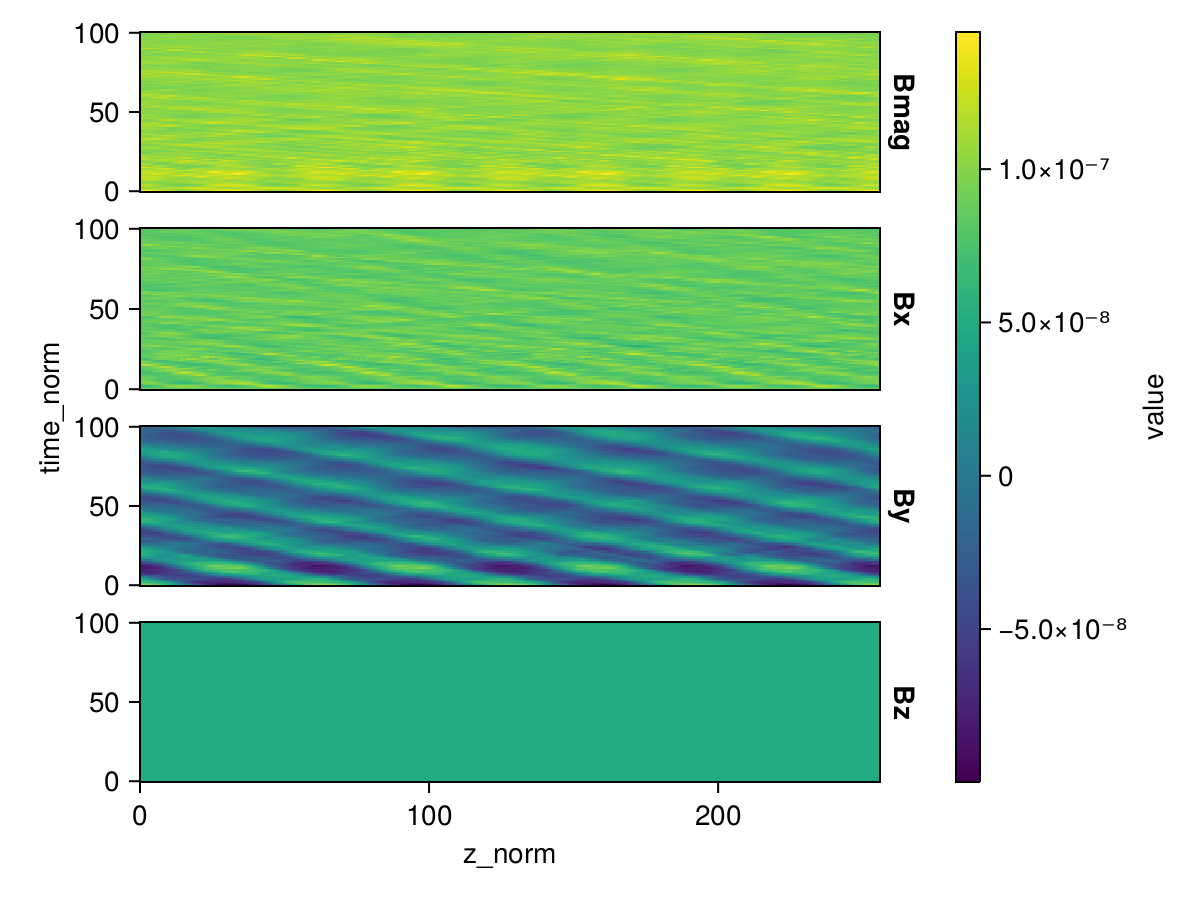

In [180]:
plot_fields(df, B_fields)

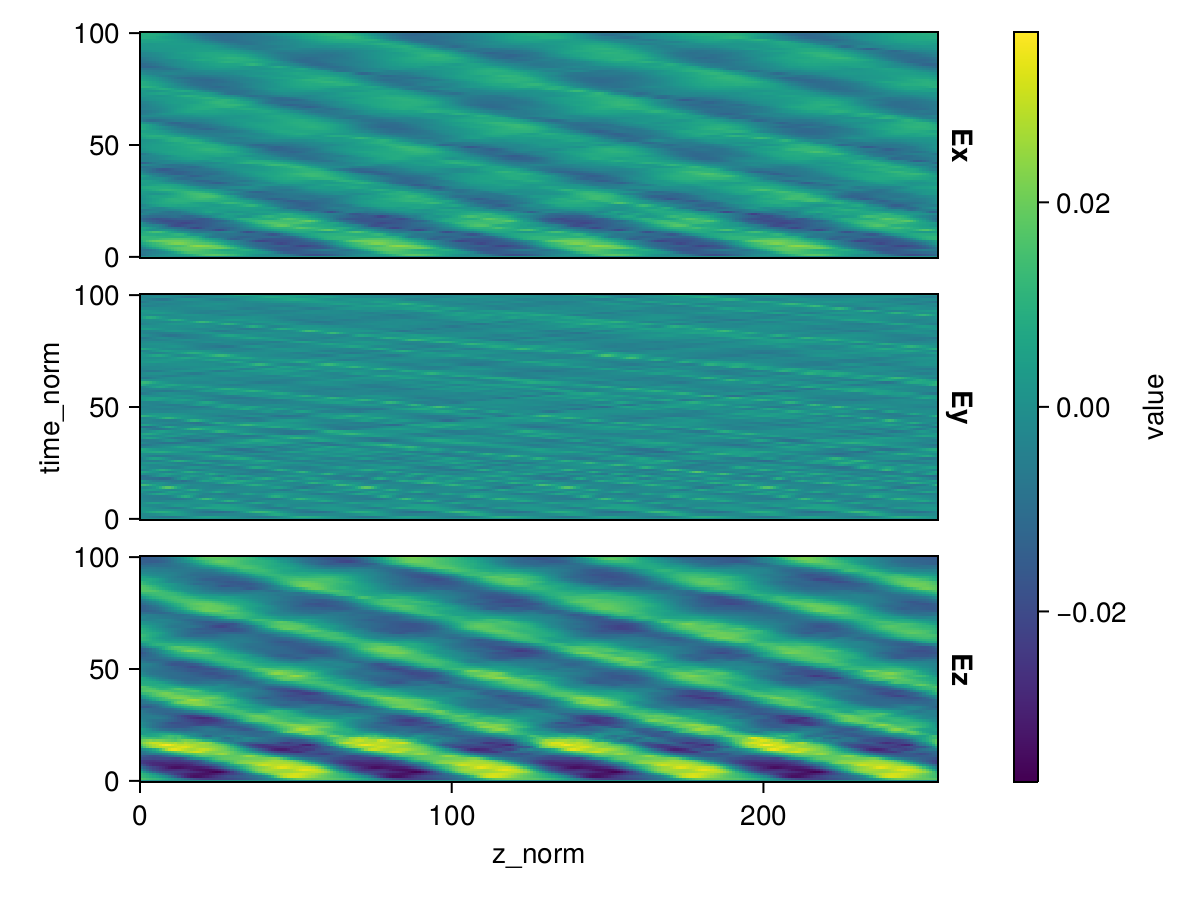

In [30]:
plot_fields(df, E_field)

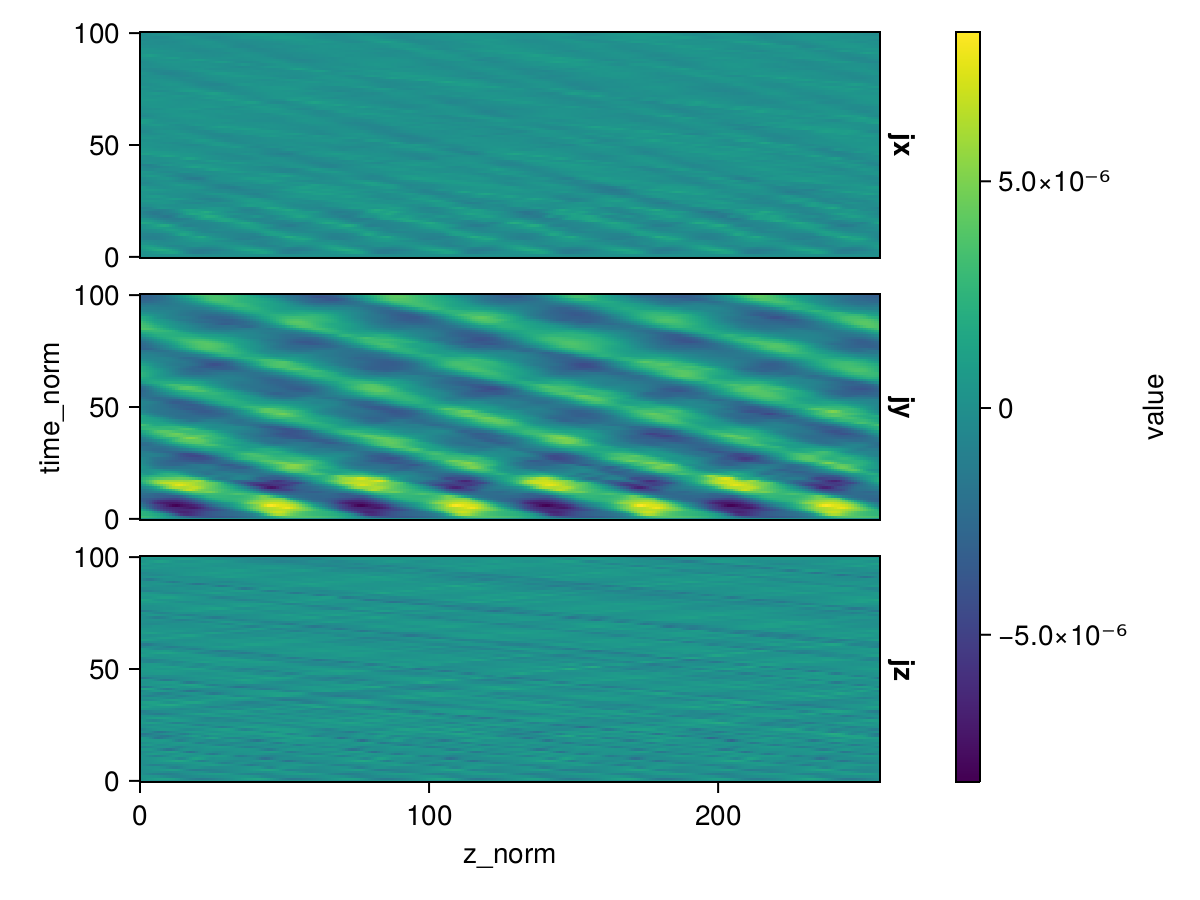

In [31]:
plot_fields(df, j_field)

In [88]:
plot_fields_time(df, B_all_fields; step=8)

ArgumentError: ArgumentError: column name :Bmag not found in the data frame

In [89]:
function plot_pressure_evolution()
    fp = "part_pressure.arrow"
    df = Arrow.Table(fp) |> DataFrame

    oldnames = ["particle_momentum_x_var", "particle_momentum_y_var", "particle_momentum_z_var"]
    newnames = ["P_xx", "P_yy", "P_zz"]
    rename!(df, oldnames .=> newnames)

    normalize_df!(df)
    stacked_df = stack(df, newnames, ids)
    data(stacked_df) * mapping(ids..., :value, row = :variable => latexify) * visual(Heatmap) |> draw
end

plot_pressure_evolution (generic function with 1 method)

## Fluid fields

In [ ]:
file = "particle.arrow"
path = joinpath(dir, file)
df = path |> Arrow.Table |> DataFrame

In [ ]:
df.z_norm = df.particle_position_z / meta["d_i"]
df.py_norm = df.particle_momentum_y / 1e-25

In [ ]:
plt = data(df) * mapping(:particle_position_z, :time,:particle_momentum_y) * visual(Heatmap)
draw(plt)

### Non-binned particle data

In [ ]:
df.time_norm = CategoricalArray(df.time ./ meta["t_ci"])

In [ ]:
z_norm_edge = 0:1:240
py_norm_edge = -1e3:10:1e3

In [ ]:
datalimits_f = x -> quantile(x, [0.05, 0.95])

In [ ]:
fig_options = (size = (1200, 1000),)

plt = data(df) * mapping(:z_norm, :py_norm, layout=:time_norm) * histogram(datalimits=datalimits_f)
p = draw(plt; figure = fig_options)

## Parameters

In [ ]:
using Pkg
Pkg.add("Symbolics")

In [ ]:
using Symbolics

In [ ]:
@variables t x y μ_0 B ρ c n q m ϵ_0

Alfven_speed = B / sqrt(μ_0 * ρ)

# plasma frequency
ω_p = sqrt(n * q / (m * ϵ_0))
# inertial_length
d_i = c / ω_p

# gryofrequency
ω_c = q * B / m


simplify(ω_c / ω_p)

In [ ]:
ω_c / ω_p